In [1]:
import json
import numpy as np
import cs_vqe.circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.linalg_tools as la
from utils.molecule_tools import get_molecule
from utils.cs_vqe_tools import greedy_dfs
from matplotlib import pyplot as plt
#from qat.interop.qiskit import qiskit_to_qlm
from qiskit.aqua.components.optimizers import IMFIL, NELDER_MEAD

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'H3+_STO-3G_SINGLET_alt', 'HeH+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET_alt', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET_alt', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'N+_STO-3G_SINGLET', 'OH+_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_SINGLET', 'NH_STO-3G_SINGLET', 'F+_STO-3G_SINGLET', 'Li+_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET'])

In [3]:
speciesname = "B+_STO-3G_SINGLET"
molecule    = model_data[speciesname]

ham         = molecule['ham']
uccsd       = molecule['uccsd']
hf_config   = molecule['hf_config']
num_qubits  = molecule['num_qubits']
terms_noncon= molecule['terms_noncon']
num_tapered = molecule['num_tapered']
print(num_tapered+num_qubits, num_qubits)

10 5


B+_STO-3G_SINGLET reaches chemical accuracy for 3-qubit CS-VQE


/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


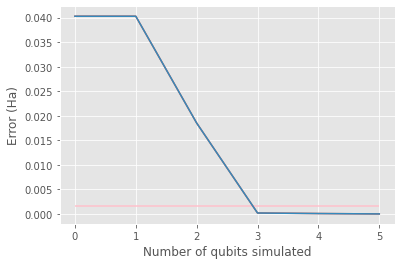

In [4]:
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
mol_circ.plot_cs_vqe_errors()

In [10]:
anz_ops = mol_circ.sufficient_anz_terms(uccsd)

Testing operator 1/176
Testing operator 2/176
Testing operator 3/176
Testing operator 4/176
Testing operator 5/176
Testing operator 6/176
Testing operator 7/176
Testing operator 8/176
Testing operator 9/176
Testing operator 10/176
Testing operator 11/176
Testing operator 12/176
Testing operator 13/176
Testing operator 14/176
Testing operator 15/176
Testing operator 16/176
Testing operator 17/176
Testing operator 18/176
Testing operator 19/176
Testing operator 20/176
Testing operator 21/176
Testing operator 22/176
Testing operator 23/176
Testing operator 24/176
Testing operator 25/176
Testing operator 26/176
Testing operator 27/176
Testing operator 28/176
Testing operator 29/176
Testing operator 30/176
Testing operator 31/176
Testing operator 32/176
Testing operator 33/176
Testing operator 34/176
Testing operator 35/176
Testing operator 36/176
Testing operator 37/176
Testing operator 38/176
Testing operator 39/176
Testing operator 40/176
Testing operator 41/176
Testing operator 42/176
T

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


Testing operator 98/176
*   Performing 3-qubit CS-VQE over qubit positions 3, 2, 1 ...
Testing operator 99/176
*   Performing 3-qubit CS-VQE over qubit positions 3, 2, 1 ...
Testing operator 100/176
*   Performing 3-qubit CS-VQE over qubit positions 3, 2, 1 ...
Testing operator 101/176
*   Performing 3-qubit CS-VQE over qubit positions 3, 2, 1 ...


KeyboardInterrupt: 

In [5]:
anz_ops = ['XIZXX', 'IYZXX'] #for B+ 
#anz_ops = ['YXIIXXII', 'IXIIZZZY', 'XYIIZZXX', 'YYIIXYII'] #for HF

anz=uccsd
#anz = {op:uccsd[op] for op in anz_ops}
anz_red = mol_circ.project_anz_terms_alt(anz_terms=anz, num_sim_q = num_sim_q)
ham_red = mol_circ.ham_reduced[num_sim_q]
qc = mol_circ.build_circuit(anz, num_sim_q)
init_params = mol_circ.init_param
print(ham_red)
print('Number of circuit parameters:', qc.num_parameters, '\n')
qc.draw()

{'III': -22.759376450174514, 'ZII': -0.6311272728526982, 'ZZI': -0.6311272728526944, 'IZI': 0.5076986661580043, 'IZZ': 3.181197200546666e-10, 'ZZZ': 0.4771381983709242, 'ZIZ': 0.4771381983709254, 'IIZ': -0.3192201279283682, 'XZI': 0.015814815627810057, 'XII': -0.015814815627810057, 'YXY': -0.026341473846094858, 'XXY': -2.175414001965564e-20, 'XYY': 9.694958679900745e-19, 'YYY': 0.04985454935653372, 'YYX': -9.694958679900745e-19, 'XYX': 0.04985454935653372, 'XXX': -0.026341473846094858, 'YXX': 2.1754140019655688e-20, 'ZYY': 0.026341473846094858, 'IYY': 6.078024888176294e-19, 'IXY': 1.1503425575762997e-18, 'ZXY': 0.04985454935653372, 'ZXX': 6.078024888176294e-19, 'IXX': 0.026341473846094858, 'IYX': -0.04985454935653372, 'ZYX': -1.1503425575762997e-18, 'IIY': -3.1812103320517926e-10, 'ZIY': 2.1185229388259594e-33, 'ZZY': 2.1185229388259594e-33, 'IZY': -3.181210329883388e-10, 'IZX': -6.020837543196889e-10, 'ZZX': -5.018921579409384e-27, 'ZIX': -5.018921579409384e-27, 'IIX': -6.020837543196

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


┌───┐ ┌─────┐┌───┐                                                     »
q_0: ─┤ X ├─┤ Sdg ├┤ H ├──■───────────────────────────■───────────────────■──»
     ┌┴───┴┐└┬───┬┘└───┘┌─┴─┐                       ┌─┴─┐┌───┐┌───┐┌───┐┌─┴─┐»
q_1: ┤ Sdg ├─┤ H ├──────┤ X ├──■─────────────────■──┤ X ├┤ H ├┤ S ├┤ H ├┤ X ├»
     ├─────┤ ├───┤      └───┘┌─┴─┐┌───────────┐┌─┴─┐└───┘└───┘└───┘└───┘└───┘»
q_2: ┤ Sdg ├─┤ H ├───────────┤ X ├┤ Rz(-P[0]) ├┤ X ├─────────────────────────»
     └─────┘ └───┘           └───┘└───────────┘└───┘                         »
«                                                                              »
«q_0: ─────────────────────────■─────────────────────■─────────────────────────»
«                            ┌─┴─┐┌───┐┌─────┐┌───┐┌─┴─┐                       »
«q_1: ──■─────────────────■──┤ X ├┤ H ├┤ Sdg ├┤ H ├┤ X ├──■─────────────────■──»
«     ┌─┴─┐┌───────────┐┌─┴─┐├───┤├───┤└┬───┬┘└───┘└───┘┌─┴─┐┌───────────┐┌─┴─┐»
«q_2: ┤ X ├┤ Rz(-P[1]) ├┤ X ├┤ H ├┤ S ├─┤ H ├───────────┤ X ├┤ Rz(-P[2]) ├┤ X ├»
«     └───┘└───────────┘└───┘└───┘└───┘ └───┘           └───┘└───────────┘└───┘»
«                                                           ┌───┐ ┌───┐┌───┐»
«q_0: ──■───────────────────■───────────────────────────■───┤ H ├─┤ S ├┤ H ├»
«     ┌─┴─┐┌───┐┌───┐┌───┐┌─┴─┐                       ┌─┴─┐ └───┘ └───┘└───┘»
«q_1: ┤ X ├┤ H ├┤ S ├┤ H ├┤ X ├──■─────────────────■──┤ X ├─────────────────»
«     └───┘└───┘└───┘└───┘└───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤┌─────┐┌───┐     »
«q_2: ─────────────────────────┤ X ├┤ Rz(-P[3]) ├┤ X ├┤ H ├┤ Sdg ├┤ H ├─────»
«                              └───┘└───────────┘└───┘└───┘└─────┘└───┘     »
«                                                                              »
«q_0: ──■───────────────────────────■─────────────────────■────────────────────»
«     ┌─┴─┐                       ┌─┴─┐┌───┐┌─────┐┌───┐┌─┴─┐                  »
«q_1: ┤ X ├──■─────────────────■──┤ X ├┤ H ├┤ Sdg ├┤ H ├┤ X ├──■───────────────»
«     └───┘┌─┴─┐┌───────────┐┌─┴─┐└───┘└───┘└─────┘└───┘└───┘┌─┴─┐┌───────────┐»
«q_2: ─────┤ X ├┤ Rz(-P[4]) ├┤ X ├───────────────────────────┤ X ├┤ Rz(-P[5]) ├»
«          └───┘└───────────┘└───┘                           └───┘└───────────┘»
«                                                                           »
«q_0: ───────■───────────────────■───────────────────────────■──────────────»
«          ┌─┴─┐┌───┐┌───┐┌───┐┌─┴─┐                       ┌─┴─┐┌───┐┌─────┐»
«q_1: ──■──┤ X ├┤ H ├┤ S ├┤ H ├┤ X ├──■─────────────────■──┤ X ├┤ H ├┤ Sdg ├»
«     ┌─┴─┐├───┤├───┤├───┤└───┘└───┘┌─┴─┐┌───────────┐┌─┴─┐└───┘└───┘└─────┘»
«q_2: ┤ X ├┤ H ├┤ S ├┤ H ├──────────┤ X ├┤ Rz(-P[6]) ├┤ X ├─────────────────»
«     └───┘└───┘└───┘└───┘          └───┘└───────────┘└───┘                 »
«                                           ┌───┐┌─────┐┌───┐          »
«q_0: ───────■───────────────────────────■──┤ H ├┤ Sdg ├┤ H ├──■───────»
«     ┌───┐┌─┴─┐                       ┌─┴─┐├───┤└┬───┬┘├───┤┌─┴─┐     »
«q_1: ┤ H ├┤ X ├──■─────────────────■──┤ X ├┤ H ├─┤ S ├─┤ H ├┤ X ├──■──»
«     └───┘└───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤└───┘ └───┘ └───┘└───┘┌─┴─┐»
«q_2: ──────────┤ X ├┤ Rz(-P[7]) ├┤ X ├┤ H ├──────────────────────┤ X ├»
«               └───┘└───────────┘└───┘└───┘                      └───┘»
«                                                                              »
«q_0: ────────────────────■─────────────────────■───────────────────────────■──»
«                       ┌─┴─┐┌───┐┌─────┐┌───┐┌─┴─┐                       ┌─┴─┐»
«q_1: ───────────────■──┤ X ├┤ H ├┤ Sdg ├┤ H ├┤ X ├──■─────────────────■──┤ X ├»
«     ┌───────────┐┌─┴─┐└───┘└───┘└─────┘└───┘└───┘┌─┴─┐┌───────────┐┌─┴─┐└───┘»
«q_2: ┤ Rz(-P[8]) ├┤ X ├───────────────────────────┤ X ├┤ Rz(-P[9]) ├┤ X ├─────»
«     └───────────┘└───┘                           └───┘└───────────┘└───┘     »
«                                                                  »
«q_0: ─────────────────■──────────────────■─────────────────────■──»
«     ┌───┐

# Performing the simulation *without* noise

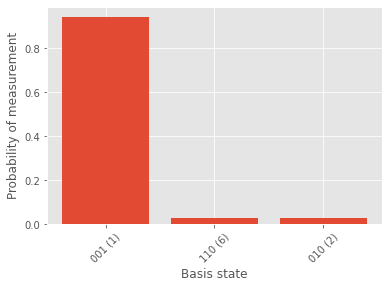

*   Performing 3-qubit CS-VQE over qubit positions 3, 2, 1 ...


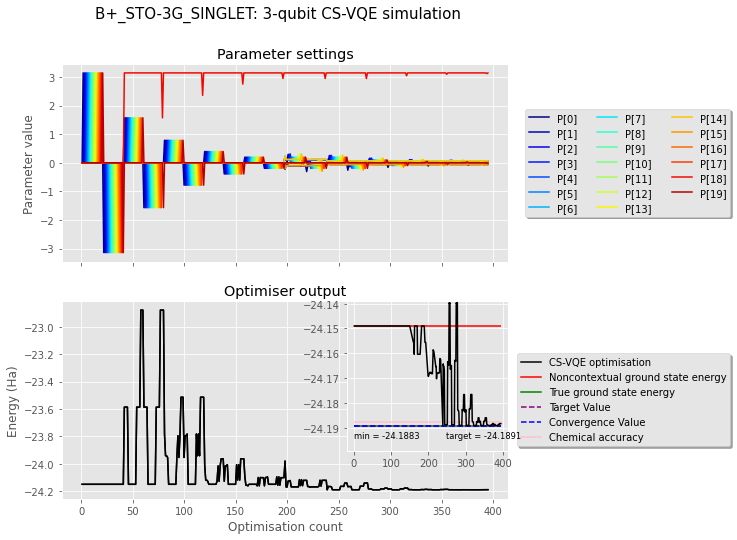

In [13]:
cs_vqe_results = mol_circ.CS_VQE(anz_terms=anz, 
                                 num_sim_q=num_sim_q, 
                                 optimizer=IMFIL(maxiter=10000), 
                                 param_bound=np.pi,
                                 noise=False,
                                show_amps=True)

title = '%s: %i-qubit CS-VQE simulation' % (speciesname, num_sim_q)
fig = plot.plot_parameter_settings(cs_vqe_results, title=title)

In [14]:
list(zip(*list(cs_vqe_results['params'].values())))[0]

(0.0,
 0.0,
 -4.440892098500626e-16,
 8.881784197001252e-16,
 8.881784197001252e-16,
 -4.440892098500626e-16,
 0.0,
 0.0,
 0.0,
 0.0,
 -8.881784197001252e-16,
 4.440892098500626e-16,
 8.881784197001252e-16,
 4.440892098500626e-16,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0)

In [48]:
num_sim_q

3

In [49]:
instructions=[]
param_num=0
for gate, q_pos, blank in qc.data:
    var = gate.params
    if var != []:
        var = [param_num%qc.num_parameters]
        param_num += 1
    instructions.append((gate.name.upper(), var, [q.index for q in q_pos]))

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  


In [50]:
instructions

[('X', [], [0]),
 ('SDG', [], [2]),
 ('H', [], [2]),
 ('SDG', [], [1]),
 ('H', [], [1]),
 ('SDG', [], [0]),
 ('H', [], [0]),
 ('CX', [], [0, 1]),
 ('CX', [], [1, 2]),
 ('RZ', [0], [2]),
 ('CX', [], [1, 2]),
 ('CX', [], [0, 1]),
 ('H', [], [1]),
 ('S', [], [1]),
 ('H', [], [1]),
 ('CX', [], [0, 1]),
 ('CX', [], [1, 2]),
 ('RZ', [1], [2]),
 ('CX', [], [1, 2]),
 ('CX', [], [0, 1]),
 ('H', [], [2]),
 ('S', [], [2]),
 ('H', [], [1]),
 ('H', [], [2]),
 ('SDG', [], [1]),
 ('H', [], [1]),
 ('CX', [], [0, 1]),
 ('CX', [], [1, 2]),
 ('RZ', [2], [2]),
 ('CX', [], [1, 2]),
 ('CX', [], [0, 1]),
 ('H', [], [1]),
 ('S', [], [1]),
 ('H', [], [1]),
 ('CX', [], [0, 1]),
 ('CX', [], [1, 2]),
 ('RZ', [3], [2]),
 ('CX', [], [1, 2]),
 ('CX', [], [0, 1]),
 ('H', [], [2]),
 ('H', [], [0]),
 ('S', [], [0]),
 ('SDG', [], [2]),
 ('H', [], [2]),
 ('H', [], [0]),
 ('CX', [], [0, 1]),
 ('CX', [], [1, 2]),
 ('RZ', [4], [2]),
 ('CX', [], [1, 2]),
 ('CX', [], [0, 1]),
 ('H', [], [1]),
 ('SDG', [], [1]),
 ('H', [], [1]

In [ ]:
qc_qlm = qiskit_to_qlm(qc)

In [ ]:
instructions=[]
param_num=0
for gate, var, q_pos in list(qc_qlm.iterate_simple()):
    if var!=[]:
        var=[param_num%num_sim_q]
        param_num += 1
    instructions.append((gate, var, q_pos))

In [ ]:
qc_qlm_dict = {'hamiltonian':ham_red,
               'num_qubits':qc_qlm.nbqbits,
               'num_params':qc.num_parameters,
               'instructions':instructions}

In [ ]:
qc_qlm_dict

In [16]:
import json 
 
with open("data/QLM_circuits/B+_UCCSD.json", "r") as outfile: 
    circuit = json.dump(qc_qlm_dict, outfile)

FileNotFoundError: [Errno 2] No such file or directory: 'data/QLM_circuits/B+_UCCSD.json'